
# **Práctica 3: Transformers**

- Rubén Gil Martínez


**CODIFICACIÓN.**

- Integer: se construye una tabla con todos los tokens considerados y se le asigna un índice entero a cada token. Luego a cada token de la secuencia se le asigna el índice correspondiente. Como las secuencias tienen tamaños diferentes, se suele configurar para que los vectores de salida tengan el tamaño de la secuencia más larga asignándose un 0 a los valores de relleno (*padding*).

- Multi-hot: la codificación de salida es un vector binario cuyo tamaño es el número de tokens considerados, si un token aparece en la secuencia codificada el vector tendrá un 1 en la posición correspondiente a ese token, si no un 0. Independientemente del tamaño de la secuencia a codificar, la salida será un vector cuyo tamaño se corresponde con la longitud del vocabulario. # |V| TAMAÑO DEL VECTOR PARA CADA TOKEN

- TF-IDF: es una extensión de multi-hot que en lugar de valores binarios asigna la frecuencia de aparición de un token en un conjunto de datos.


---


La librería Keras proporciona la clase [TextVectorization](https://keras.io/api/layers/preprocessing_layers/text/text_vectorization/) que implementa una capa para la codificación de texto.

### El problema: clasificación de péptidos
<a class='anchor' id='problema'></a>

Durante esta práctica abordaremos el problema de la clasificación de fragmentos de texto. En concreto, nos centraremos en la clasificación de péptidos, secuencias de AAs, codificadas mediante caracteres de texto. Los péptidos se pueden agrupar en dos clases según presenten o no actividad antimicrobiana (AMP). Los CSV de entrada están separados entre los AMP y los no AMP, así que deberán fusionarse para construir un dataset que permita un entrenamiento supervisado.

En las diferentes sesiones de esta práctica construiremos diferentes modelos para resolver este problema. El punto de partida será la arquitectura genérica MLP, utilizaremos también redes neuronales recurrentes (RNN) para estudiar la ventaja de procesar datos en forma de secuencia y finalmente implementaremos un Transformer que se ha convertido en el modelo de referencia para este tipo de datos.




In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras
from keras import layers, Sequential, optimizers
# CONJUNTO DE ENTRENAMIENTO DE LA CODIFICACIÓN: TODOS LAS CADENAS DE AMINOACIDOS, UTILIZAR ADAPT Y EMPLEAR PARA CODIFICAR CORRECTAMENTE CADA CARÁCTER DENTRO DE LA CADENA

**E1:** Carga las tablas almacenadas en los CSV utilizando la librería Pandas y fusiónalas en un solo Dataframe. Después construye una lista con todos los péptidos y otra cuyos elementos sean booleanos identificando si son AMP. ¿Cuál es la secuencia más larga? ¿Cuántos AAs diferentes hay? ¿Cuál es el vocabulario del lenguaje?

In [2]:
# Cargamos los datasets de péptidos antimicrobianos y péptidos sin efecto antimicrobiano en dataframes
peptidos_AM = pd.read_csv('../data/dataset_p3/veltri_dramp_cdhit_90.csv', sep=',')
perptidos_sin_efecto_AM =  pd.read_csv('../data/dataset_p3/non_amp_ampep_cdhit90.csv', sep=',')



# Fusionamos los dataframes para tener todos los péptidos en un único dataframe
peptidos = pd.concat([peptidos_AM, perptidos_sin_efecto_AM], ignore_index=True)



# Preprocesamiento y preparación de las cadenas de aminoácidos para su posterior codificación
# Eliminación de columnas innecesarias y conversión de las secuencias de aminoácidos a mayúsculas
peptidos.drop(columns=['Unnamed: 0'], inplace=True)
peptidos['aa_seq'] = peptidos['aa_seq'].str.upper()



# Listas con todos los péptidos y su respectiva clasificación
PEPTIDOS =list(peptidos['aa_seq'])
AMP = list(peptidos['AMP'])



# Análisis de los péptidos
print(f"Secuencia de aminoácidos más larga: {PEPTIDOS[np.argmax(peptidos['aa_len'])]}")
AAs = "".join(set("".join(PEPTIDOS)))
print(f"Número de aminoácidos diferentes: {len(AAs)}")
print(f"Vocabulario de aminoácidos: {sorted(AAs)}")

Secuencia de aminoácidos más larga: LGKFSQTCYNSAIQGSVLTSTCERTNGGYNTSSIDLNSVIENVDGSLKWQPSNFIETCRNTQLAGSSELAAECKTRAQQFVSTKINLDDHIANIDGTLKYE
Número de aminoácidos diferentes: 25
Vocabulario de aminoácidos: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


**E2:** Divide los conjuntos de datos del E1 en dos. Uno que contenga el 80% de las secuencias para el entrenamiento supervisado y otro que contenga al resto para testear los modelos entrenados. Asegúrate que en ambos conjuntos hay una selección representativos de péptidos.

**E3:** Codifica los péptidos empleando la codificación multi-hot. ¿Qué longitud tiene cada péptido codificado? **Cada péptido codificado tiene una longitud de 25, es decir, la longitud del vocabulario ya que se asocia un 1 en el índice del vector de codificación en caso de que el carácter asociado a ese índice aparezca en la secuencia y un 0 en caso contrario.**

**DIVISIÓN DEL DATASET EN ENTRENAMIENTO Y TEST (80/20):**

In [19]:
X_train, X_test, y_train, y_test = train_test_split(PEPTIDOS, AMP, test_size=0.2, random_state=76, stratify=AMP)

# Análisis de los péptidos para asegurarnos que se ha realizado una partición donde ambos conjuntos sean representativos
AAs_X_train = "".join(set("".join(X_train)))
AAs_X_test = "".join(set("".join(X_test)))


print(f"Número de aminoácidos diferentes Entrenamiento: {len(AAs_X_train)}")
print(f"Vocabulario de aminoácidos Entrenamiento: {sorted(AAs_X_train)}")
print(f"Número de aminoácidos diferentes Test: {len(AAs_X_test)}")
print(f"Vocabulario de aminoácidos Test: {sorted(AAs_X_test)}")
print()
print('Partición estratificada de los datos mediante la variable objetivo:')
print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))

Número de aminoácidos diferentes Entrenamiento: 25
Vocabulario de aminoácidos Entrenamiento: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
Número de aminoácidos diferentes Test: 22
Vocabulario de aminoácidos Test: ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'X', 'Y']

Partición estratificada de los datos mediante la variable objetivo:
(array([False,  True]), array([1526, 1652]))
(array([False,  True]), array([382, 413]))


**CODIFICACIÓN MULTI-HOT DE LAS SECUENCIAS DE CARÁCTERES QUE REPRESENTAN A LOS PÉPTIDOS**

In [51]:
from keras.layers import TextVectorization

# Inicializar el vectorizador
vectorizer = TextVectorization(
    max_tokens=25,  # Número de aminoácidos únicos
    output_mode='multi_hot',  # Modo de salida 
    standardize=None,  # No estandarizamos
    split='character'  # Dividimos por caracteres(aminoácidos)
)

# Ajustar el vectorizador a las secuencias, nos ajustamos solo al conjunto de entrenamiento para evitar la exposición a datos de test
vectorizer.adapt(X_train)

# Transformamos los péptidos mediante la codificación multi-hot
X_train_encoded = vectorizer(X_train)
X_test_encoded = vectorizer(X_test)

In [52]:
peptidos['Multi-Hot'] = peptidos['aa_seq'].apply(lambda x: vectorizer(x).numpy())

In [57]:
# Muestra de la correcta codificación de los péptidos 
peptidos.head(8)

,aa_seq,aa_len,AMP,Multi-Hot
0,GNGVLKTISHECNMNTWQFLFTCC,24,True,"[0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, ..."
1,TTKNYGNGVCNSVNWCQCGNVWASCNLATGCAAWLCKLA,39,True,"[0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, ..."
2,SNDSLWYGVGQFMGKQANCITNHPVKHMIIPGYCLSKILG,40,True,"[0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, ..."
3,IAPIIVAGLGYLVKDAWDHSDQIISGFKKGWNGGRRK,37,True,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, ..."
4,FNRGGYNFGKSVRHVVDAIGSVAGIRGILKSIR,33,True,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, ..."
5,VFHAYSARGVRNNYKSAVGPADWVISAVRGFIHG,34,True,"[0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, ..."
6,RRSRKNGIGYAIGYAFGAVERAVLGGSRDYNK,32,True,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, ..."
7,KGLGKLIGIDWLLGQAKDAVKQYKKDYKRWH,31,True,"[0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, ..."


In [24]:
# Vocabulario de codificación
vocab = vectorizer.get_vocabulary()
char_indices = {char: idx for idx, char in enumerate(vocab)}
print("Vocabulario de carácteres e índices asociados a cada uno: \n " , char_indices, "\n")
print("Longitud de los péptidos codificados/longitud vectores multi-hot:", X_train_encoded.shape[1])


Vocabulario de carácteres e índices asociados a cada uno: 
  {'[UNK]': 0, np.str_('K'): 1, np.str_('L'): 2, np.str_('G'): 3, np.str_('A'): 4, np.str_('R'): 5, np.str_('S'): 6, np.str_('V'): 7, np.str_('I'): 8, np.str_('C'): 9, np.str_('E'): 10, np.str_('T'): 11, np.str_('P'): 12, np.str_('N'): 13, np.str_('F'): 14, np.str_('D'): 15, np.str_('Q'): 16, np.str_('Y'): 17, np.str_('M'): 18, np.str_('H'): 19, np.str_('W'): 20, np.str_('X'): 21, np.str_('U'): 22, np.str_('O'): 23, np.str_('Z'): 24} 

Longitud de los péptidos codificados/longitud vectores multi-hot: 25


**E4:** Basándote en la arquitectura del E4 de la Sesión 1 de la Práctica 2 (Redes Convolucionales), construye un MLP para clasificar los péptidos. ¿Cuántos parámetros a entrenar tiene? **Siguiendo la misma arquitectura, tenemos 185.857 parámetros entrenables.**

**E5:** Entrena el modelo del E4 utilizando el 20% de los datos de entrenamiento para validación durante el entrenamiento. Utiliza una cantidad de épocas que produzca sobreajuste, además añade un *callback* para guardar el modelo que tenga una mayor precisión en la validación.

**E6:** Testea la precisión del modelo entrenado en el E5 empleando el conjunto de test obtenido en el E2. Recuerda cargar el modelo para la mejor época. ¿Qué precisión se alcanza? **SE ALCANZA UNA PRECISIÓN DE 0.7139, NO ES MUY BUENA PERO CON LA IMPLEMENTACIÓN DE OTRAS CODIFICACIONES Y OTRAS ARQUITECTURAS QUE CAPTEN MEJOR EL CARÁCTER SECUENCIAL QUE PRESENTA ESTE PROBLEMA, CONSEGUIREMOS MEJORAR EN PRESTACIONES.**

In [44]:
# Definimos un earling stopping para detener el entrenamiento de los modelos cuando ya no mejoren la precisión de la validación
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',  # Métrica a monitorear 
    patience=50,  # Número de epochs sin mejora antes de parar
    min_delta=0.0001,  # Pequeña mejora mínima requerida
    restore_best_weights=True,  # Restaura los mejores pesos en lugar de los últimos
    verbose=1  # Muestra mensaje en la consola con la época que contiene los mejores pesos
)

In [26]:
# Obtención del 20% de los datos de entrenamiento para validación del modelo durante el proceso de entrenamiento
X_train_f, X_val_f, y_train_f, y_val_f = train_test_split(np.array(X_train_encoded), y_train, test_size=0.2, random_state=2025, stratify=y_train)

In [ ]:
# Conversión de las etiquetas a arrays de numpy para su uso en la red neuronal
y_train_f = np.array(y_train_f)
y_val_f = np.array(y_val_f)
y_test = np.array(y_test)

In [ ]:
model = Sequential([ 
    layers.Input(shape=(X_train_f.shape[1],)),
    layers.Dense(512, activation='leaky_relu'),
    layers.Dense(256, activation='leaky_relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')])

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 512)            │        13,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 185,857 (726.00 KB)

 Trainable params: 185,857 (726.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compilación del modelo previa a entrenamiento
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo
history = model.fit(X_train_f, y_train_f, epochs=150, batch_size=32, validation_data=(X_val_f, y_val_f), callbacks=[early_stopping])

Epoch 1/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6311 - loss: 0.6739 - val_accuracy: 0.6997 - val_loss: 0.6150
Epoch 2/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7178 - loss: 0.5898 - val_accuracy: 0.7028 - val_loss: 0.5692
Epoch 3/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7213 - loss: 0.5559 - val_accuracy: 0.7154 - val_loss: 0.5498
Epoch 4/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7385 - loss: 0.5284 - val_accuracy: 0.7170 - val_loss: 0.5448
Epoch 5/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7247 - loss: 0.5295 - val_accuracy: 0.7201 - val_loss: 0.5391
Epoch 6/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7667 - loss: 0.4967 - val_accuracy: 0.7280 - val_loss: 0.5375
Epoch 7/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7375 - loss: 0.5178 - val_accuracy: 0.7327 - val_loss: 0.5389
Epoch 8/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7427 - loss: 0.4963 - val_accuracy: 0.7280 - v

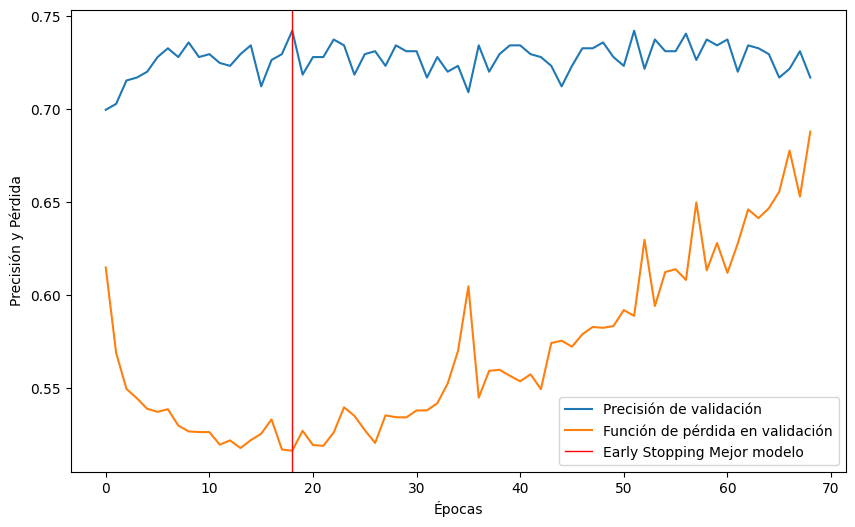

In [47]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.plot(history.history['val_loss'], label= 'Función de pérdida en validación')

plt.axvline(x=np.argmax(history.history['val_accuracy']), color='r', linestyle='-', linewidth=1, label='Early Stopping Mejor modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión y Pérdida')
plt.legend()
plt.show()

**PODEMOS OBSERVAR EN LA SIGUIENTE GRÁFICA COMO SE SELECCIONA EL MODELO DE MAYOR PRECISIÓN A PARTIR DEL EARLY STOPPING PREVIAMENTE DEFINIDO, OBSERVAR QUE EL INCREMENTO DE LA FUNCIÓN DE PÉRDIDA EN VALIDACIÓN ES UNA CLARA SEÑAL DEL SOBREAJUSTE DEL MODELO.**

In [48]:
# Testeo, predicción y evaluación del modelo
test_loss, test_acc = model.evaluate(X_test_encoded, y_test)
print(f"Test Accuracy: {test_acc}")
print(f"Test Loss: {test_loss}")


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7139 - loss: 0.5144 
Test Accuracy: 0.7371069192886353
Test Loss: 0.5032005906105042


In [49]:
predictions = model.predict(X_test_encoded[0:10])
predictions = np.where(predictions > 0.5, True, False)
print(f"Predicciones del modelo:  {predictions.T}")
print(f"Clases reales: {y_test[0:10]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
Predicciones del modelo:  [[ True  True  True  True False  True  True  True  True False]]
Clases reales: [ True False  True  True False  True False  True False False]


**E7:** Repite los ejercicios E3-6 pero esta vez empleando codificación TF-IDF. ¿Ha mejorado la precisión? ¿por qué?

**SE ALCANZA UNA PRECISIÓN DE 0.8275, SE CONSIGUE UNA CONSIDERABLE MEJORA EN LA PRECISIÓN.**
**ESTA SE DA POR EL CAMBIO DE CODIFICACIÓN REALIZADO, CON TF-IDF BRINDAMOS A LA RED DE MUCHA MÁS INFORMACIÓN SOBRE LA DISTRIBUCIÓN/APARICIÓN DE LOS AMINOÁCIDOS EN LOS DISTINTOS PÉPTIDOS, COMO POSTERIORMENTE SERÁ COMENTADO, ESTA CODIFICACIÓN BRINDA LA SIGUIENTE INFORMACIÓN A NIVEL DE AMINOÁCIDO:** 

- NÚMERO DE VECES QUE APARECE EN EL PROPIO PÉPTIDO
- IMPORTANCIA DE ESTE MEDIDA A PARTIR DE LA CANTIDAD DE PÉPTIDOS EN LOS QUE APARECE


In [ ]:
# Inicializar el vectorizador
vectorizer = TextVectorization(
    max_tokens=25,  # Número de aminoácidos únicos
    output_mode='tf-idf',  # Modo de salida 
    standardize=None,  # No estandarizamos
    split='character'  # Dividimos por caracteres(aminoácidos)
)

# Ajustar el vectorizador a las secuencias, nos ajustamos solo al conjunto de entrenamiento para evitar la exposición a datos de test
vectorizer.adapt(X_train)

# Transformamos los péptidos mediante la codificación TF-IDF
X_train_encoded = vectorizer(X_train)
X_test_encoded = vectorizer(X_test)

In [ ]:
peptidos['TF-IDF'] = peptidos['aa_seq'].apply(lambda x: vectorizer(x).numpy())

In [60]:
# Mostramos la correcta codificación de los péptidos mediante TF-IDF
peptidos.head(8)

,aa_seq,aa_len,AMP,Multi-Hot,TF-IDF
0,GNGVLKTISHECNMNTWQFLFTCC,24,True,"[0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, ...","[0.0, 0.79246056, 1.5467752, 1.56601, 0.0, 0.0..."
1,TTKNYGNGVCNSVNWCQCGNVWASCNLATGCAAWLCKLA,39,True,"[0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, ...","[0.0, 1.5849211, 2.3201628, 3.13202, 4.0539956..."
2,SNDSLWYGVGQFMGKQANCITNHPVKHMIIPGYCLSKILG,40,True,"[0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, ...","[0.0, 2.3773818, 2.3201628, 3.915025, 0.810799..."
3,IAPIIVAGLGYLVKDAWDHSDQIISGFKKGWNGGRRK,37,True,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, ...","[0.0, 3.1698422, 1.5467752, 4.69803, 2.4323974..."
4,FNRGGYNFGKSVRHVVDAIGSVAGIRGILKSIR,33,True,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, ...","[0.0, 1.5849211, 0.7733876, 4.69803, 1.6215982..."
5,VFHAYSARGVRNNYKSAVGPADWVISAVRGFIHG,34,True,"[0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, ...","[0.0, 0.79246056, 0.0, 3.13202, 4.0539956, 2.6..."
6,RRSRKNGIGYAIGYAFGAVERAVLGGSRDYNK,32,True,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, ...","[0.0, 1.5849211, 0.7733876, 4.69803, 3.2431965..."
7,KGLGKLIGIDWLLGQAKDAVKQYKKDYKRWH,31,True,"[0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, ...","[0.0, 5.547224, 3.0935504, 3.13202, 1.6215982,..."


In [ ]:
# Vocabulario de codificación
vocab = vectorizer.get_vocabulary()
char_indices = {char: idx for idx, char in enumerate(vocab)}
print("Vocabulario de carácteres e índices asociados a cada uno: \n " , char_indices, "\n")
print("Longitud de los péptidos codificados/longitud vectores multi-hot:", X_train_encoded.shape[1])

Vocabulario de carácteres e índices asociados a cada uno: 
  {'[UNK]': 0, np.str_('K'): 1, np.str_('L'): 2, np.str_('G'): 3, np.str_('A'): 4, np.str_('R'): 5, np.str_('S'): 6, np.str_('V'): 7, np.str_('I'): 8, np.str_('C'): 9, np.str_('E'): 10, np.str_('T'): 11, np.str_('P'): 12, np.str_('N'): 13, np.str_('F'): 14, np.str_('D'): 15, np.str_('Q'): 16, np.str_('Y'): 17, np.str_('M'): 18, np.str_('H'): 19, np.str_('W'): 20, np.str_('X'): 21, np.str_('U'): 22, np.str_('O'): 23, np.str_('Z'): 24} 

Longitud de los péptidos codificados/longitud vectores multi-hot: 25


**Cada péptido codificado sigue teniendo una longitud de 25, es decir, la longitud del vocabulario de aminoácidos pero en este caso no realizamos una codificación binaria sino que seguimos el modelo de codificación basado en la normalización por frecuencia de token(aminoácido) en el propio péptido junto a la frecuencia de aparición de este en las diversas muestras de péptidos.**

La frecuencia de término mide cuántas veces aparece un token en un péptido, se usa la variante logarítmica para evitar que los aminoácidos muy frecuentes dominen.

$$
TF(t, d) = 1 + \log_{10} (f_{t,d}) \quad \text{si } f_{t,d} > 0
$$

Si el token **no aparece** en el péptido, se define como:

$$
TF(t, d) = 0 \quad \text{si } f_{t,d} = 0
$$

---
La **IDF** mide la importancia de un aminoácido considerando en cuántos péptidos aparece, si aparece en todos su importancia se reduce pero si no es my frecuente puede ser que le de a la red información fundamental para tomar una decisión:


$$
IDF(t) = \log \left( \frac{N}{DF_t + 1} \right)
$$


---

**Cálculo del TF-IDF**

El **TF-IDF** se calcula multiplicando **TF** por **IDF**:

$$
TF\text{-}IDF(t, d) = TF(t, d) \times IDF(t)
$$

Así es como se obtiene la codificación de cada aminoácido de los diferentes péptidos del conjunto de datos.


In [ ]:
# Obtención del 20% de los datos de entrenamiento para validación del modelo durante el proceso de entrenamiento
X_train_f, X_val_f, y_train_f, y_val_f = train_test_split(np.array(X_train_encoded), y_train, test_size=0.2, random_state=2025, stratify=y_train)

# Conversión de las etiquetas a arrays de numpy para su uso en la red neuronal
y_train_f = np.array(y_train_f)
y_val_f = np.array(y_val_f)
y_test = np.array(y_test)

In [77]:
model_tfidf = Sequential([ 
    layers.Input(shape=(X_train_f.shape[1],)),
    layers.Dense(512, activation='leaky_relu'),
    layers.Dense(256, activation='leaky_relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')])

model_tfidf.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_40 (Dense)                │ (None, 512)            │       249,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 421,889 (1.61 MB)

 Trainable params: 421,889 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compilación del modelo previa a entrenamiento
model_tfidf.compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo
history = model_tfidf.fit(X_train_f, y_train_f, epochs=150, batch_size=32, validation_data=(X_val_f, y_val_f), callbacks=[early_stopping])

Epoch 1/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6374 - loss: 0.6181 - val_accuracy: 0.7469 - val_loss: 0.5341
Epoch 2/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7678 - loss: 0.5107 - val_accuracy: 0.7704 - val_loss: 0.5015
Epoch 3/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7816 - loss: 0.4907 - val_accuracy: 0.7830 - val_loss: 0.4753
Epoch 4/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7973 - loss: 0.4480 - val_accuracy: 0.8019 - val_loss: 0.4599
Epoch 5/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8084 - loss: 0.4353 - val_accuracy: 0.7893 - val_loss: 0.4494
Epoch 6/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8183 - loss: 0.3979 - val_accuracy: 0.8082 - val_loss: 0.4353
Epoch 7/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8157 - loss: 0.3916 - val_accuracy: 0.7925 - val_loss: 0.4344
Epoch 8/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8262 - loss: 0.3747 - val_accuracy: 0.8035 - v

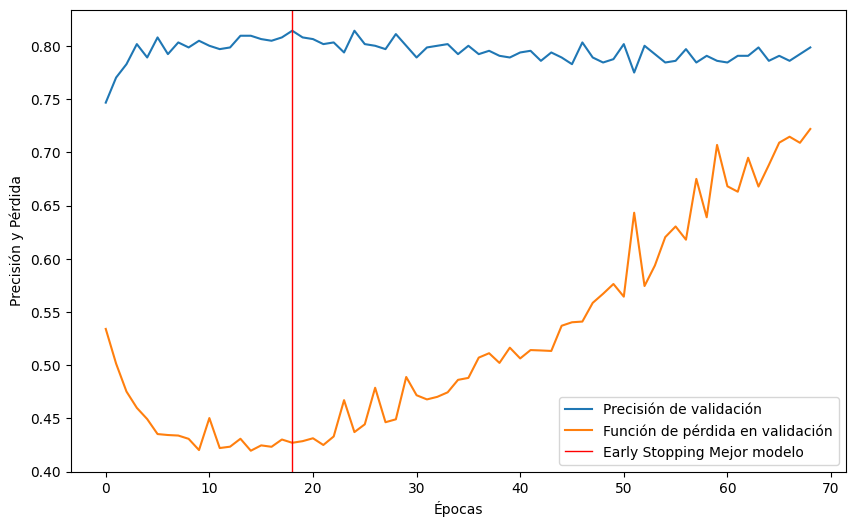

In [66]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.plot(history.history['val_loss'], label= 'Función de pérdida en validación')

plt.axvline(x=np.argmax(history.history['val_accuracy']), color='r', linestyle='-', linewidth=1, label='Early Stopping Mejor modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión y Pérdida')
plt.legend()
plt.show()

In [67]:
# Testeo, predicción y evaluación del modelo
test_loss, test_acc = model_tfidf.evaluate(X_test_encoded, y_test)
print(f"Test Accuracy: {test_acc}")
print(f"Test Loss: {test_loss}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8275 - loss: 0.4043 
Test Accuracy: 0.8251572251319885
Test Loss: 0.42199262976646423


**E8:** Hasta ahora hemos trabajado solo con unigramas, los tokens están compuesto por AAs aislados. También es posible construir tokens con combinaciones de AAs (n-gramas). Repite el ejercicio E7 pero esta vez empleando bigramas. ¿Qué tamaño tiene el vocabulario ahora? ¿Por qué MLP ha aumentado considerablemente el número de parámetros a entrenar? ¿Qué ventaja podría aportar el trabajar con n-gramas (n > 1) en comparación de unigramas?

**Ahora el vocabulario tiene un tamaño de 486 tokens diferentes, a los 25 únicos se les añade todas las distintas combinaciones de parejas de aminoácidos.**

**Porque ahora, la entrada del modelo no es un vector de tamaño 25, sino que se da un input mucho mayor, esto lleva a que en la primera capa del modelo hayan muchos más parámetros a ajustar. Se puede observar claramente en el resumen de la construcción de la arquitectura, en los modelos anteriores la primera capa contiene 13.312 parámetros entrenables y este nuevo modelo contiene 249.344 parámetros entrenable solamente en la primera capa.**

**El uso de bigramas nos podría ayudar a mejorar la precisión del modelo ya que este va a ser capaz de capturar:**
- Interacciones locales entre residuos
- Información primordial que proporcionan parejas de aminoácidos sobre la función biológica del péptido
- Similitudes en secuencias cortas

In [69]:
# Inicializar el vectorizador
vectorizer = TextVectorization(
    max_tokens=None,  # Número de aminoácidos únicos
    output_mode='tf-idf',  # Modo de salida 
    standardize=None,  # No estandarizamos
    split='character',  # Dividimos por caracteres(aminoácidos)
    ngrams=(1, 2)  # Incluimos n-gramas de 1 y 2 caracteres
)

# Ajustar el vectorizador a las secuencias, nos ajustamos solo al conjunto de entrenamiento para evitar la exposición a datos de test
vectorizer.adapt(X_train)

# Transformamos los péptidos mediante la codificación TF-IDF con el uso de bigramas
X_train_encoded = vectorizer(X_train)
X_test_encoded = vectorizer(X_test)

In [70]:
peptidos['TF-IDF_with_bigrams'] = peptidos['aa_seq'].apply(lambda x: vectorizer(x).numpy())
peptidos.head(8)

,aa_seq,aa_len,AMP,Multi-Hot,TF-IDF,TF-IDF_with_bigrams
0,GNGVLKTISHECNMNTWQFLFTCC,24,True,"[0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, ...","[0.0, 0.79246056, 1.5467752, 1.56601, 0.0, 0.0...","[0.0, 0.79246056, 1.5467752, 1.56601, 0.0, 0.0..."
1,TTKNYGNGVCNSVNWCQCGNVWASCNLATGCAAWLCKLA,39,True,"[0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, ...","[0.0, 1.5849211, 2.3201628, 3.13202, 4.0539956...","[0.0, 1.5849211, 2.3201628, 3.13202, 4.0539956..."
2,SNDSLWYGVGQFMGKQANCITNHPVKHMIIPGYCLSKILG,40,True,"[0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, ...","[0.0, 2.3773818, 2.3201628, 3.915025, 0.810799...","[0.0, 2.3773818, 2.3201628, 3.915025, 0.810799..."
3,IAPIIVAGLGYLVKDAWDHSDQIISGFKKGWNGGRRK,37,True,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, ...","[0.0, 3.1698422, 1.5467752, 4.69803, 2.4323974...","[0.0, 3.1698422, 1.5467752, 4.69803, 2.4323974..."
4,FNRGGYNFGKSVRHVVDAIGSVAGIRGILKSIR,33,True,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, ...","[0.0, 1.5849211, 0.7733876, 4.69803, 1.6215982...","[0.0, 1.5849211, 0.7733876, 4.69803, 1.6215982..."
5,VFHAYSARGVRNNYKSAVGPADWVISAVRGFIHG,34,True,"[0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, ...","[0.0, 0.79246056, 0.0, 3.13202, 4.0539956, 2.6...","[0.0, 0.79246056, 0.0, 3.13202, 4.0539956, 2.6..."
6,RRSRKNGIGYAIGYAFGAVERAVLGGSRDYNK,32,True,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, ...","[0.0, 1.5849211, 0.7733876, 4.69803, 3.2431965...","[0.0, 1.5849211, 0.7733876, 4.69803, 3.2431965..."
7,KGLGKLIGIDWLLGQAKDAVKQYKKDYKRWH,31,True,"[0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, ...","[0.0, 5.547224, 3.0935504, 3.13202, 1.6215982,...","[0.0, 5.547224, 3.0935504, 3.13202, 1.6215982,..."


In [71]:
vocab = vectorizer.get_vocabulary()
char_indices = {char: idx for idx, char in enumerate(vocab)}
print("Vocabulario de carácteres e índices asociados a cada uno: \n " , char_indices, "\n")
print("Longitud de los péptidos codificados/longitud vectores multi-hot:", X_train_encoded.shape[1])

Vocabulario de carácteres e índices asociados a cada uno: 
  {'[UNK]': 0, np.str_('K'): 1, np.str_('L'): 2, np.str_('G'): 3, np.str_('A'): 4, np.str_('R'): 5, np.str_('S'): 6, np.str_('V'): 7, np.str_('I'): 8, np.str_('C'): 9, np.str_('E'): 10, np.str_('T'): 11, np.str_('P'): 12, np.str_('N'): 13, np.str_('F'): 14, np.str_('D'): 15, np.str_('Q'): 16, np.str_('Y'): 17, np.str_('M'): 18, np.str_('H'): 19, np.str_('W'): 20, np.str_('K K'): 21, np.str_('R R'): 22, np.str_('L L'): 23, np.str_('G G'): 24, np.str_('L K'): 25, np.str_('A A'): 26, np.str_('A K'): 27, np.str_('K L'): 28, np.str_('G K'): 29, np.str_('G L'): 30, np.str_('L A'): 31, np.str_('L G'): 32, np.str_('K R'): 33, np.str_('A L'): 34, np.str_('K A'): 35, np.str_('K G'): 36, np.str_('K I'): 37, np.str_('S L'): 38, np.str_('L S'): 39, np.str_('A G'): 40, np.str_('R K'): 41, np.str_('S G'): 42, np.str_('V L'): 43, np.str_('V K'): 44, np.str_('I K'): 45, np.str_('F L'): 46, np.str_('K V'): 47, np.str_('R L'): 48, np.str_('I L'):

In [72]:
# Obtención del 20% de los datos de entrenamiento para validación del modelo durante el proceso de entrenamiento
X_train_f, X_val_f, y_train_f, y_val_f = train_test_split(np.array(X_train_encoded), y_train, test_size=0.2, random_state=2025, stratify=y_train)

# Conversión de las etiquetas a arrays de numpy para su uso en la red neuronal
y_train_f = np.array(y_train_f)
y_val_f = np.array(y_val_f)
y_test = np.array(y_test)

In [86]:
# Definimos un earling stopping para detener el entrenamiento de los modelos cuando ya no mejoren la precisión de la validación
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',  # Métrica a monitorear 
    patience=80,  # Número de epochs sin mejora antes de parar
    min_delta=0.00001,  # Pequeña mejora mínima requerida
    restore_best_weights=True,  # Restaura los mejores pesos en lugar de los últimos
    verbose=1  # Muestra mensaje en la consola con la época que contiene los mejores pesos
)

In [85]:
model_tfidf_bigram = Sequential([ 
    layers.Input(shape=(X_train_f.shape[1],)),
    layers.Dense(512, activation='leaky_relu'),
    layers.BatchNormalization(),
    layers.Dense(256, activation='leaky_relu'),
    layers.BatchNormalization(),
    layers.Dense(128, activation='leaky_relu'),
    layers.BatchNormalization(),
    layers.Dense(64, activation='leaky_relu'),
    layers.Dense(1, activation='sigmoid')])
model_tfidf_bigram.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_60 (Dense)                │ (None, 512)            │       249,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 425,473 (1.62 MB)

 Trainable params: 423,681 (1.62 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [87]:
# Compilación del modelo previa a entrenamiento
model_tfidf_bigram.compile(optimizer=optimizers.Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo
history = model_tfidf_bigram.fit(X_train_f, y_train_f, epochs=200, batch_size=64, validation_data=(X_val_f, y_val_f), callbacks=[early_stopping])

Epoch 1/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4925 - loss: 0.8678 - val_accuracy: 0.5299 - val_loss: 0.7016
Epoch 2/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5632 - loss: 0.7508 - val_accuracy: 0.5708 - val_loss: 0.6791
Epoch 3/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5933 - loss: 0.7081 - val_accuracy: 0.6006 - val_loss: 0.6585
Epoch 4/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6128 - loss: 0.6660 - val_accuracy: 0.6242 - val_loss: 0.6399
Epoch 5/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6491 - loss: 0.6263 - val_accuracy: 0.6478 - val_loss: 0.6222
Epoch 6/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6561 - loss: 0.6156 - val_accuracy: 0.6745 - val_loss: 0.6068
Epoch 7/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7096 - loss: 0.5758 - val_accuracy: 0.6965 - val_loss: 0.5922
Epoch 8/200
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7283 - loss: 0.5542 - val_accuracy: 0.6981 - v

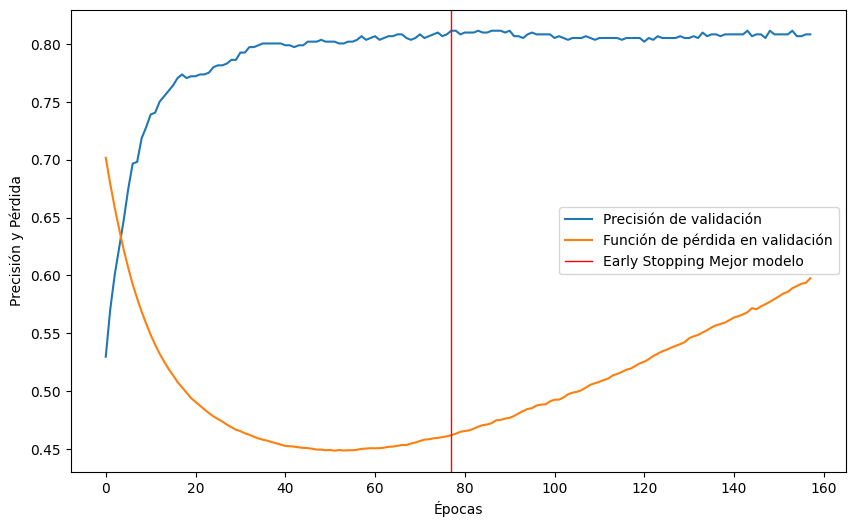

In [88]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.plot(history.history['val_loss'], label= 'Función de pérdida en validación')

plt.axvline(x=np.argmax(history.history['val_accuracy']), color='r', linestyle='-', linewidth=1, label='Early Stopping Mejor modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión y Pérdida')
plt.legend()
plt.show()

In [89]:
# Testeo, predicción y evaluación del modelo
test_loss, test_acc = model_tfidf_bigram.evaluate(X_test_encoded, y_test)
print(f"Test Accuracy: {test_acc}")
print(f"Test Loss: {test_loss}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8051 - loss: 0.4871 
Test Accuracy: 0.796226441860199
Test Loss: 0.48771166801452637
